In [6]:
import os
import mne
import pycartool.io
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt

import umap
from features import *
from my_io import *

D:\Python\envs\epilespy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read EEG data

In [7]:
files = list()

base_folder = fr'V:\switchdrive\Brainhack'
for subject_folder in os.listdir(base_folder):
    subject_folder = os.path.join(base_folder, subject_folder)
    if os.path.isdir(subject_folder):
        for day_folder in os.listdir(subject_folder):
            day_folder = os.path.join(subject_folder, day_folder)
            if os.path.isdir(day_folder):
                for file in os.listdir(day_folder):
                    if file.endswith('.sef'):
                        file = os.path.join(day_folder, file)
                        files.append(file)
files

['V:\\switchdrive\\Brainhack\\KMR1\\d11\\KMR1_d11_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d13\\KMR1_d13_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d15\\KMR1_d15_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d17\\KMR1_d17_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d19\\KMR1_d19_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d21\\KMR1_d21_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d23\\KMR1_d23_Raw_DS.Avg_Ref.Export.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d23\\KMR1_d23_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d25\\KMR1_d25_Raw_DS.Avg_Ref.Export.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d25\\KMR1_d25_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d27\\KMR1_d27_Raw_DS.Avg_Ref.Export.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d27\\KMR1_d27_Raw_DS.Avg_Ref.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d29\\KMR1_d29_Raw_DS.Avg_Ref.Export.sef',
 'V:\\switchdrive\\Brainhack\\KMR1\\d29\\KMR1_d29

In [24]:
file.split("\\")

['V:',
 'switchdrive',
 'Brainhack',
 'KMR1',
 'd25',
 'KMR1_d25_Raw_DS.Avg_Ref.sef']

In [9]:
all_features = []
for file in files:
    try:
        day = file.split("\\")[4]
        subject = file.split("\\")[3]
        features = []
        raw = read_file(file)
        raw.pick(['e11'])
        raw.filter(1., None)
        events, events_id = mne.events_from_annotations(raw, chunk_duration=1)
        epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')
        data = epochs.get_data()

        activity_features = activity(data)
        features.append(activity_features)

        mobility_features = mobility(data)
        features.append(mobility_features)

        complexity_features = complexity(data)
        features.append(complexity_features)

        time_features = extract_time_feat(data)
        features.append(time_features.reshape((time_features.shape[0],-1)))

        frequency_features = extract_freq_feat(data, sfreq=epochs.info['sfreq'])
        features.append(frequency_features.reshape((frequency_features.shape[0],-1)))

        information_features = extract_information_feat(data, sfreq=epochs.info['sfreq'])
        features.append(information_features.reshape((information_features.shape[0],-1)))

        dwt_features = extract_dwt_feat(data)
        features.append(dwt_features.reshape((dwt_features.shape[0],-1)))

        events = epochs.events[:,2].reshape(-1,1)
        features.append(events)

        days = np.array([day] * len(epochs)).reshape(-1,1)
        features.append(days)

        subjects = np.array([subject] * len(epochs)).reshape(-1,1)
        features.append(subjects)

        features = np.hstack(features)
        all_features.append(features)
    except Exception as e:
        print(file , e)


df = pd.DataFrame(np.vstack(all_features))

[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14403520
    Range : 0 ... 14403519 =      0.000 ...  3600.880 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 295 events and 4001 original time points ...
12 bad epochs dropped


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15108480
    Range : 0 ... 15108479 =      0.000 ...  3777.120 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 298 events and 4001 original time points ...
25 bad epochs dropped


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14402816
    Range : 0 ... 14402815 =      0.000 ...  3600.704 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
263 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 263 events and 4001 original time points ...
20 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=16680001
    Range : 0 ... 16680000 =      0.000 ...  4170.000 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 309 events and 4001 original time points ...
37 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14405568
    Range : 0 ... 14405567 =      0.000 ...  3601.392 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
256 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 256 events and 4001 original time points ...
26 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=16560001
    Range : 0 ... 16560000 =      0.000 ...  4140.000 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
250 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 250 events and 4001 original time points ...
41 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=6, n_times=16113472
    Range : 0 ... 16113471 =      0.000 ...  4028.368 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 170 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=16113472
    Range : 0 ... 16113471 =      0.000 ...  4028.368 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
170 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 170 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=3, n_times=17209792
    Range : 0 ... 17209791 =      0.000 ...  4302.448 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
334 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 334 events and 4001 original time points ...
0 bad epochs dropped


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=17209792
    Range : 0 ... 17209791 =      0.000 ...  4302.448 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
334 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 334 events and 4001 original time points ...
0 bad epochs dropped


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=6, n_times=14440000
    Range : 0 ... 14439999 =      0.000 ...  3610.000 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14440000
    Range : 0 ... 14439999 =      0.000 ...  3610.000 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 216 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=3, n_times=14403200
    Range : 0 ... 14403199 =      0.000 ...  3600.800 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 282 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14403200
    Range : 0 ... 14403199 =      0.000 ...  3600.800 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 282 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15019520
    Range : 0 ... 15019519 =      0.000 ...  3754.880 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 4001 original time points ...
28 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14475008
    Range : 0 ... 14475007 =      0.000 ...  3618.752 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR1\d5\KMR1_d5_Raw_DS.Avg_Ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14409280
    Range : 0 ... 14409279 =      0.000 ...  3602.320 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
272 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 272 events and 4001 original time points ...
26 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14487168
    Range : 0 ... 14487167 =      0.000 ...  3621.792 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
283 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 283 events and 4001 original time points ...


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


17 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15724608
    Range : 0 ... 15724607 =      0.000 ...  3931.152 secs
Ready.
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR11\d11\KMR11_d11_Raw_DS.Avg_ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15708224
    Range : 0 ... 15708223 =      0.000 ...  3927.056 secs
Ready.
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR11\d13\KMR11_d13_Raw_DS.Avg_ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15297920
    Range : 0 ... 15297919 =      0.000 ...  3824.480 secs
Ready.
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR11\d15\KMR11_d15_Raw_DS.Avg_ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
269 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 269 events and 4001 original time points ...
32 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15095488
    Range : 0 ... 15095487 =      0.000 ...  3773.872 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 301 events and 4001 original time points ...


C:\Users\Victor\AppData\Local\Temp\ipykernel_15956\3236722822.py:11: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id=events_id, tmin=0, tmax=1, baseline=None, on_missing='ignore')


0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15011648
    Range : 0 ... 15011647 =      0.000 ...  3752.912 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
255 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 255 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=15503680
    Range : 0 ... 15503679 =      0.000 ...  3875.920 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
239 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 239 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=16750720
    Range : 0 ... 16750719 =      0.000 ...  4187.680 secs
Ready.
Epileptic_events.mrk
mrk_bck.mrk
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 13201 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


Used Annotations descriptions: ['background', 'hpd', 'null']
Not setting metadata
321 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 321 events and 4001 original time points ...
0 bad epochs dropped
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14781376
    Range : 0 ... 14781375 =      0.000 ...  3695.344 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR6\d3\KMR6_d3_Raw_DS.Avg_Ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Creating RawArray with float64 data, n_channels=16, n_times=14806720
    Range : 0 ... 14806719 =      0.000 ...  3701.680 secs
Ready.
bad_epoch_v4.mrk
Epileptic_events.mrk
V:\switchdrive\Brainhack\KMR6\d5\KMR6_d5_Raw_DS.Avg_Ref.sef 'start'
[sef.read_sef] INFO: Cannot read recording date from file: year 0 is out of range
Crea

In [10]:
df = pd.DataFrame(np.vstack(all_features))
df.add_prefix('col_')

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_40,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49
0,3796.218891476905,0.10358956505681109,7.41652883842653,-9.037120014083404,3796.218891476905,-0.01361651584631476,-0.27101505679289506,0.042310069966689665,40.73645804517081,0.009168543713767779,...,-0.31891073230244604,0.2774954955296784,0.3972075062038131,271.2978892011893,-0.49177564393866796,19.35940940833128,0.24106553265784322,1,d11,KMR1
1,4111.727865829195,0.1140019831864083,7.1430072283168915,30.70353975821557,4111.727865829195,-0.16804976847250927,0.4908845189286084,-0.011914065939216267,53.437874546090306,0.1148975264722748,...,0.3415010094845159,0.31031224084683445,0.7030917979233593,236.20415765100248,0.26632236355041516,0.7048608732414561,0.2839541232540674,1,d11,KMR1
2,6929.870276902492,0.090263321651406,8.948944077647692,8.883552279962872,6929.870276902492,-0.35201661980551713,0.5619003776076514,-0.012460157061599428,56.460891027641466,-0.2120642389261466,...,0.03352858875629661,0.2700873149003066,0.49808449650704617,237.70680599096005,-0.08338140851917479,1.1255706702665504,0.2771344367476112,1,d11,KMR1
3,1803.4483691104974,0.17262933007072367,4.48236488558545,-13.637019306967545,1803.4483691104974,-0.2891762624973357,0.10393994956748687,0.01383393695913445,53.74435853457116,0.11549392708939302,...,0.5691117434517108,0.28651446566876987,0.840159412417316,296.4895296705827,-0.11296718147936126,3.231956469351527,0.2636166991063765,1,d11,KMR1
4,5493.955240974365,0.0900776849123256,8.817658033244033,3.0384950392663304,5493.955240974365,-0.5248745805205879,-0.09319323561382031,-0.017741635974349215,44.57789414523223,0.021441406940422847,...,0.5585184823996734,0.2658446850491207,-0.25832707551564843,203.7238376009878,-0.0033902373833179823,3.5920389038005798,0.25287820358793284,1,d11,KMR1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5546,8198.142876682035,0.0723987829852594,9.722601511498212,2.3755164721562783,8198.142876682035,-0.025657071899442378,-0.9342342726391344,-0.006724939058933741,42.971252710066096,-0.1559266524228053,...,3.2327515621867153,0.25357658103635006,0.24416281220580746,461.0655256897434,-0.9847254030740782,11.222989920028896,0.3520256973371875,2,d29,KMR6
5547,4878.9410568072535,0.06554369540037015,12.03151318509201,16.24213368464696,4878.9410568072535,-0.06636561792312867,-0.07142289843867378,-0.004767483634724012,20.9598137183256,-0.10327963824854011,...,1.0687311463544518,0.26271139559582884,-0.009150633961638958,88.00733953516436,-0.08975023047586417,4.655040854341661,0.2837026657820288,1,d29,KMR6
5548,15111.69838782159,0.05213712349238519,14.083183179803088,13.104782242135455,15111.69838782159,-0.09030520200386918,-1.0397207399657165,0.029861614377624638,41.07782214501652,0.012455532809501374,...,3.391868229116497,0.28644887744772357,-0.28839375260571704,451.6904297045388,-0.3047648023783451,9.40834229695688,0.3508301376096665,2,d29,KMR6
5549,5165.034370905506,0.08314719539572457,8.92840500137206,-25.486373322119444,5165.034370905506,-0.08891409823014988,-0.6003586894616291,0.009706692355768277,35.708238389479256,-0.08469225888062366,...,3.946363887261186,0.26446301915408543,-0.4208660044137886,281.67208384510434,-1.3658825648779398,12.748226568195001,0.3091290128778328,2,d29,KMR6


In [45]:
df[49].unique()

array(['KMR1', 'KMR6'], dtype=object)

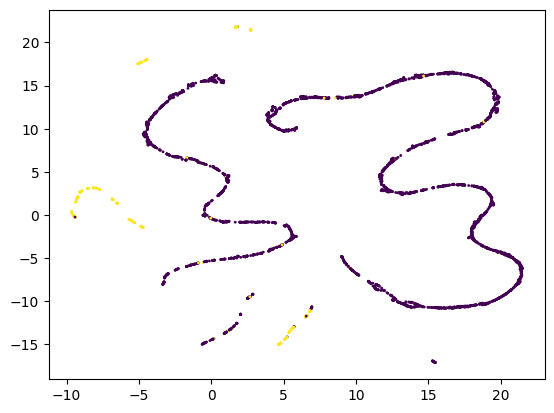

In [51]:
%matplotlib inline
fit = umap.UMAP()
df_ = df[df[49] == 'KMR1']
data = df_.values[:,:-4]
u = fit.fit_transform(data)
plt.scatter(u[:,0], u[:,1], c=df_.values[:,-3].astype(int), s=1)

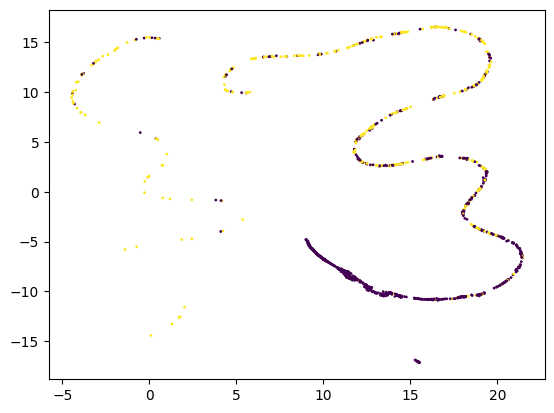

In [52]:
df_ = df[df[49] == 'KMR6']
data = df_.values[:,:-4]
u = fit.transform(data)
plt.scatter(u[:,0], u[:,1], c=df_.values[:,-3].astype(int), s=1)

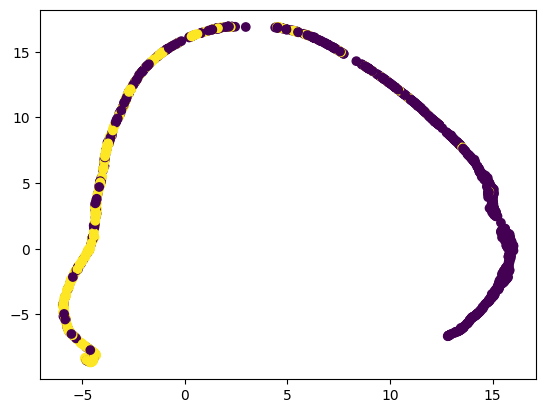

In [46]:
%matplotlib inline
fit = umap.UMAP(n_neighbors=100)
df_ = df[df[49] == 'KMR6']
data = df_.values[:,:-4]
u = fit.fit_transform(data)
plt.scatter(u[:,0], u[:,1], c=df_.values[:,-3].astype(int))

In [36]:
plt.scatter(u[:,0], u[:,1], c=df_.values[:,-3].astype(int))

In [38]:
umap.plot.connectivity(fit, show_points=True,  edge_bundling='hammer')

D:\Python\envs\epilespy\lib\site-packages\umap\plot.py:885: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot: >

### Umap

In [11]:
fit = umap.UMAP()
data = df.values[:,:-4]
u = fit.fit_transform(data)

In [27]:
import umap.plot 
umap.plot.output_notebook()

hover_data = df.iloc[: , -2:]
hover_data.columns = ['day', 'subject']

p = umap.plot.interactive(fit, labels=df.values[:,-3].astype(int),
                          hover_data=hover_data,
                          point_size=4,
                          theme='fire',
                          background='black')
umap.plot.show(p)

Loading BokehJS ...